<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Outbreak_Detection_Evaluation_(Mosquito_Borne_Disease).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The outbreak detection evaluation framework in this analysis is based on dengue data from the dataset published in:
https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0009259

In [33]:
import numpy as np
import pandas as pd
import string
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import  f1_score, precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

## Open Dataset

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
dengue_cucuta_path = '/content/drive/My Drive/Mosquito_Data/dengue_cucuta.csv'

dengue_cucuta = pd.read_csv(dengue_cucuta_path)
dengue_cucuta.head(3)

,Municipality,Year,Week_inY,Reported_Cases,Population,Week,Farrington_Flexible,EARS,ARIMA,Farrington_Flexible_pval,ARIMA_pval
0,Cucuta,2009,1,52,612175,105,0,0,0,0.251926,0.153714
1,Cucuta,2009,2,44,612175,106,0,0,0,0.395594,0.736659
2,Cucuta,2009,3,49,612175,107,0,0,0,0.443009,0.484496


In [36]:
dengue_bello_path = '/content/drive/My Drive/Mosquito_Data/dengue_bello.csv'

dengue_bello = pd.read_csv(dengue_bello_path)
dengue_bello.head(3)

,Municipality,Year,Week_inY,Reported_Cases,Population,Week,Farrington_Flexible,EARS,ARIMA,Farrington_Flexible_pval,ARIMA_pval
0,Bello,2009,1,1,404895,105,0,0,0,0.986344,0.924936
1,Bello,2009,2,1,404895,106,0,0,0,0.777817,0.862709
2,Bello,2009,3,1,404895,107,0,0,0,0.500000,0.935754


In [37]:
dengue_moni_path = '/content/drive/My Drive/Mosquito_Data/dengue_moni.csv'

dengue_moni = pd.read_csv(dengue_moni_path)
dengue_moni.tail(3)

,Municipality,Year,Week_inY,Reported_Cases,Population,Week,Farrington_Flexible,EARS,ARIMA,Farrington_Flexible_pval,ARIMA_pval
465,Moniquira,2017,50,1,21284,570,0,0,0,0.000000,0.352702
466,Moniquira,2017,51,0,21284,571,0,0,0,0.773373,0.652819
467,Moniquira,2017,52,0,21284,572,0,0,0,0.773373,0.551469


Import Scan Statistics Data

In [38]:
scan11y_path = '/content/drive/My Drive/Mosquito_Data/scan_detect_11y.csv'

scan_11y = pd.read_csv(scan11y_path)
scan_11y['Week_inY'] = scan_11y['Week']

# To have the same format as the other detector
first_week = dengue_cucuta['Week'][0]
scan_11y["Week"] = (scan_11y.groupby("Municipality").cumcount().add(first_week))
scan_11y = scan_11y.drop(columns=["Year", "Week_inY", "Population" ])
scan_11y = scan_11y.rename(columns={'MC_pvalue': "p_val", "Dengue_total": "Reported_Cases"})
# Since there is no p_val outside the cluster, i just put the value to be 1 (to then rather put easier to convert to the weight)
scan_11y["p_val"] = scan_11y["p_val"].fillna(1)
scan_11y.tail(3)

,Municipality,Week,Reported_Cases,p_val,signal
1401,Moniquira,570,1,0.001,1
1402,Moniquira,571,0,0.001,1
1403,Moniquira,572,0,0.001,1


In [39]:
scan3y_path = '/content/drive/My Drive/Mosquito_Data/scan_detect_3y.csv'

scan_3y = pd.read_csv(scan3y_path)
scan_3y['Week_inY'] = scan_3y['Week']

# To have the same format as the other detector
first_week = dengue_cucuta['Week'][0]
scan_3y["Week"] = (scan_3y.groupby("Municipality").cumcount().add(first_week))
scan_3y = scan_3y.drop(columns=["Year", "Week_inY", "Population" ])
scan_3y = scan_3y.rename(columns={'MC_pvalue': "p_val", "Dengue_total": "Reported_Cases"})
# Since there is no p_val outside the cluster, i just put the value to be 1 (to then rather put easier to convert to the weight)
scan_3y["p_val"] = scan_3y["p_val"].fillna(1)
scan_3y.tail(3)

,Municipality,Week,Reported_Cases,p_val,signal
1401,Moniquira,570,1,1.0,0
1402,Moniquira,571,0,1.0,0
1403,Moniquira,572,0,1.0,0


## Label The Ground Truth
Labeling the outbreak on the datapoints that are above the 75th percentile. This is based on the approach of https://www.nature.com/articles/s41598-024-81367-1.

The outbreak datapoints well be determined using the relative incidence globally.

In [40]:
dengue_cucuta.head(2)

,Municipality,Year,Week_inY,Reported_Cases,Population,Week,Farrington_Flexible,EARS,ARIMA,Farrington_Flexible_pval,ARIMA_pval
0,Cucuta,2009,1,52,612175,105,0,0,0,0.251926,0.153714
1,Cucuta,2009,2,44,612175,106,0,0,0,0.395594,0.736659


In [41]:
cases_cucuta = dengue_cucuta.loc[:, ["Municipality", "Reported_Cases","Week", "Population"]].copy()
cases_bello = dengue_bello.loc[:, ["Municipality", "Reported_Cases","Week", "Population"]].copy()
cases_moni = dengue_moni.loc[:, ["Municipality", "Reported_Cases","Week", "Population"]].copy()

cases_total = pd.DataFrame({
    'Reported_Cases': (
        cases_cucuta['Reported_Cases'] +
        cases_bello['Reported_Cases'] +
        cases_moni['Reported_Cases']
    ),
    "Population": (
        cases_cucuta['Population'] +
        cases_bello['Population'] +
        cases_moni['Population']
    ),
    "Week": cases_cucuta['Week']
})

cases_total['Incidence'] = cases_total['Reported_Cases']/cases_total['Population']*100000

# Determine the threshold
thres_percent = 75
thres_total = np.percentile(cases_total['Incidence'], thres_percent)
print("Threshold global based on incidence is", round(thres_total,2))
cases_total['data_label'] = np.where(cases_total['Incidence'] > thres_total, 'dengue', 'endemic')
print("\n Example from global data:")
cases_total.head(3)

Threshold global based on incidence is 9.26

 Example from global data:


,Reported_Cases,Population,Week,Incidence,data_label
0,54,1038786,105,5.198376,endemic
1,45,1038786,106,4.331980,endemic
2,50,1038786,107,4.813311,endemic


In [42]:
cases_cucuta['data_label'] = cases_total['data_label']
cases_cucuta['Incidence'] = cases_cucuta['Reported_Cases']/cases_cucuta['Population']*100000
cases_cucuta.head(3)

,Municipality,Reported_Cases,Week,Population,data_label,Incidence
0,Cucuta,52,105,612175,endemic,8.494303
1,Cucuta,44,106,612175,endemic,7.187487
2,Cucuta,49,107,612175,endemic,8.004247


In [43]:
cases_bello['data_label'] = cases_total['data_label']
cases_bello['Incidence'] = cases_bello['Reported_Cases']/cases_bello['Population']*100000

cases_bello.head(3)

,Municipality,Reported_Cases,Week,Population,data_label,Incidence
0,Bello,1,105,404895,endemic,0.246978
1,Bello,1,106,404895,endemic,0.246978
2,Bello,1,107,404895,endemic,0.246978


In [44]:
cases_moni['data_label'] = cases_total['data_label']
cases_moni['Incidence'] = cases_moni['Reported_Cases']/cases_moni['Population']*100000

cases_moni.head(3)

,Municipality,Reported_Cases,Week,Population,data_label,Incidence
0,Moniquira,1,105,21716,endemic,4.6049
1,Moniquira,0,106,21716,endemic,0.0000
2,Moniquira,0,107,21716,endemic,0.0000


In [64]:
def plot_outbreak(dfs, city_names, colors_base):

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10),sharex=False, sharey=True)

    for ax, df, city_name, color_base in zip(axes, dfs, city_names, colors_base):

        weeks = df["Week"].to_numpy()
        incidence = df["Incidence"].to_numpy()
        labels = df["data_label"].to_numpy()

        points = np.column_stack((weeks, incidence)).reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        colors_segments = ["red" if lbl == "dengue" else color_base for lbl in labels[:-1]]

        # Add Line
        lc = LineCollection(segments, colors=colors_segments, linewidths=2)
        ax.add_collection(lc)

        endemic_mask = labels == "endemic"
        outbreak_mask = labels == "dengue"

        # Add dots
        ax.scatter(
            weeks[endemic_mask],
            incidence[endemic_mask],
            color=color_base,
            s=10,
            label="Endemic"
        )
        ax.scatter(
            weeks[outbreak_mask],
            incidence[outbreak_mask],
            color="red",
            s=10,
            label="Outbreak"
        )

        ax.set_xlim(weeks.min(), weeks.max())
        ax.set_ylim(0, incidence.max() * 1.1)
        ax.set_title(city_name)
        ax.set_ylabel("Incidence (per 100,000 people)")
        ax.grid(True, which="both", linestyle="--", alpha=1)
        ax.legend()

    axes[-1].set_xlabel("Week")
    # fig.suptitle("Dengue Cases Relative Incidence", fontsize=16)
    fig.tight_layout()
    plt.show()

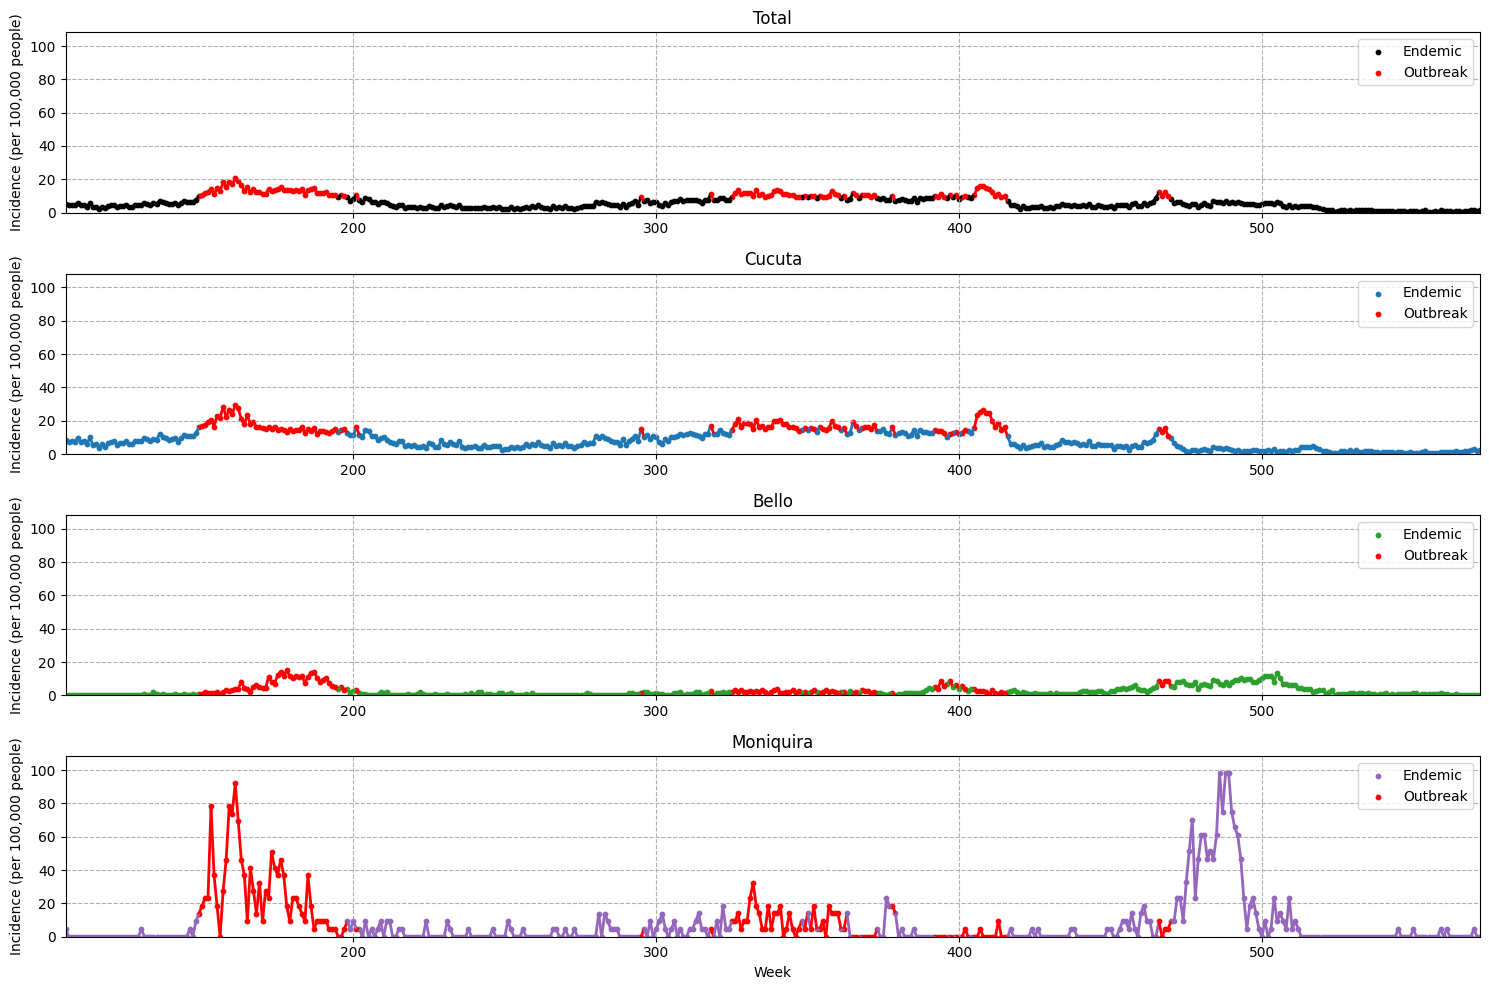

In [65]:
dfs = [cases_total, cases_cucuta, cases_bello, cases_moni]
city_names = ["Total", "Cucuta", "Bello", "Moniquira"]
colors_base = ["black", "tab:blue", "tab:green", "tab:purple"]

plot_outbreak(dfs, city_names, colors_base)

## Formatting The DataFrame to Work With Epi-Quark

In [47]:
def complete_data(df, x1, x2, label_col, val_col, fill_val=0, extra_labels=None):
    """
    Expands the DataFrame to all combinations of x1, x2, label_col,
    filling missing value_col with fill_value (default=0).

    INPUT
    df : Input DataFrame
    x1 : Column name of the first axis
    x2 : Column name of the second axis
    label_col : Name of the label column.
    val_col : Name of the value column to fill.
    fill_val: Value to fill for missing entries (default: 0).
    """
    # Take unique values from each axis and disease label
    all_x1 = df[x1].unique()
    all_x2 = df[x2].unique()
    all_labels = df[label_col].unique()

    if extra_labels is not None: # Added the endemic and non_case if not already exist in the data
      all_labels = np.unique(np.concatenate([all_labels, np.array(extra_labels)]))

    # Build full index
    full_index = pd.MultiIndex.from_product([all_x1, all_x2, all_labels], names=[x1, x2, label_col])
    full_grid = full_index.to_frame(index=False)


    merged = pd.merge(
        full_grid,
        df[[x1, x2, label_col, val_col]],
        on=[x1, x2, label_col],
        how='left'
    )

    # Fill the missing values with 0
    original_dtype = df[val_col].dtype
    merged[val_col] = merged[val_col].fillna(fill_val).astype(original_dtype)

    merged = merged.drop_duplicates()

    return merged

### Formatting the cases dataframe

In [48]:
cases = pd.concat([cases_cucuta, cases_bello, cases_moni], ignore_index=True)
cases = cases.rename(columns={'Reported_Cases': 'value'})
# cases['value'] = cases['Reported_Cases']/cases['Population']*100000
cases.head(4)

,Municipality,value,Week,Population,data_label,Incidence
0,Cucuta,52,105,612175,endemic,8.494303
1,Cucuta,44,106,612175,endemic,7.187487
2,Cucuta,49,107,612175,endemic,8.004247
3,Cucuta,45,108,612175,endemic,7.350839


In [49]:
cases = complete_data(cases, x1='Municipality', x2='Week', label_col='data_label', val_col='value')
cases.head(4)

,Municipality,Week,data_label,value
0,Cucuta,105,endemic,52
1,Cucuta,105,dengue,0
2,Cucuta,106,endemic,44
3,Cucuta,106,dengue,0


### Formatting the signal dataframe

In [50]:
signal_all = pd.concat([dengue_cucuta, dengue_bello, dengue_moni], ignore_index=True).drop(columns=['Year', 'Week_inY'])

In [51]:
def signal_split_label(df, col):
    default_cols = ['Municipality', 'Week', 'Reported_Cases']
    all_cols = default_cols + [col]
    sig = df[all_cols].copy()

    # Label the signal
    sig['signal_label'] = 'non_case'
    sig.loc[(sig[col] == 1), 'signal_label'] = 'outbreak_dengue'
    sig.loc[(sig[col] == 0) & (sig['Reported_Cases'] > 0), 'signal_label'] = 'endemic'
    return sig

In [52]:
def assign_weight(df1, df2):
    df2_merged = df2.merge(
        df1[["Municipality", "Week", "Reported_Cases", "p_val"]],
        on=["Municipality", "Week"],
        how="left"
    )

    # Initialize everything as 0
    df2_merged["value"] = 0.0

    # For the case where Reported_Cases == 0 → non_case = 1 and else 0
    zero_cases = df2_merged["Reported_Cases"] == 0
    mask_non_case = zero_cases & (df2_merged["signal_label"] == "non_case")
    df2_merged.loc[mask_non_case, "value"] = 1.0

    # For the case where Reported_Cases > 0 → endemic = p_val
    mask_endemic = (df2_merged["Reported_Cases"] > 0) & (df2_merged["signal_label"] == "endemic")
    df2_merged.loc[mask_endemic, "value"] = df2_merged.loc[mask_endemic, "p_val"].values

    # For the case where Reported_Cases > 0 → outbreak = 1-p_val
    mask_outbreak = (df2_merged["Reported_Cases"] > 0) & (df2_merged["signal_label"] == "outbreak_dengue")
    df2_merged.loc[mask_outbreak, "value"] = (1.0 - df2_merged.loc[mask_outbreak, "p_val"].values)

    return df2_merged

Formatting Signal Farrington Flexible

In [53]:
# Filled the information of outbreak, endemic, and non_case
signal_FF = signal_split_label(signal_all, 'Farrington_Flexible')
signal_FF['value'] = 0
signal_FF = complete_data(signal_FF, x1='Municipality', x2='Week', label_col='signal_label', val_col='value')
# Assign Weight
sig_FF_pval = signal_all.loc[:,['Municipality','Reported_Cases', 'Week', 'Farrington_Flexible_pval']].copy()
sig_FF_pval = sig_FF_pval.rename(columns={'Farrington_Flexible_pval': "p_val"})
signal_FF = assign_weight(sig_FF_pval, signal_FF)
signal_FF.head(6)

,Municipality,Week,signal_label,value,Reported_Cases,p_val
0,Cucuta,105,endemic,0.251926,52,0.251926
1,Cucuta,105,outbreak_dengue,0.748074,52,0.251926
2,Cucuta,105,non_case,0.000000,52,0.251926
3,Cucuta,106,endemic,0.395594,44,0.395594
4,Cucuta,106,outbreak_dengue,0.604406,44,0.395594
5,Cucuta,106,non_case,0.000000,44,0.395594


Formatting Signal ARIMA

In [54]:
# Filled the information of outbreak, endemic, and non_case
signal_arima = signal_split_label(signal_all, 'ARIMA')
signal_arima['value'] = 0
signal_arima = complete_data(signal_arima, x1='Municipality', x2='Week', label_col='signal_label', val_col='value')
# Assign Weight
sig_arima_pval = signal_all.loc[:,['Municipality','Reported_Cases', 'Week', 'ARIMA_pval']].copy()
sig_arima_pval = sig_arima_pval.rename(columns={'ARIMA_pval': "p_val"})
signal_arima = assign_weight(sig_arima_pval, signal_arima)
signal_arima.tail(6)

,Municipality,Week,signal_label,value,Reported_Cases,p_val
4206,Moniquira,571,endemic,0.0,0,0.652819
4207,Moniquira,571,outbreak_dengue,0.0,0,0.652819
4208,Moniquira,571,non_case,1.0,0,0.652819
4209,Moniquira,572,endemic,0.0,0,0.551469
4210,Moniquira,572,outbreak_dengue,0.0,0,0.551469
4211,Moniquira,572,non_case,1.0,0,0.551469


Formatting Signal Scan Statistics on The Whole Time Series

In [55]:
scan_11y_edited = signal_split_label(scan_11y, 'signal')
scan_11y_edited['value'] = 0 #Intialize 'value' column
scan_11y_edited = complete_data(scan_11y_edited, x1='Municipality', x2='Week', label_col='signal_label', val_col='value')

# Assign Weight (a bit not straightforward in handling the data, but this is so that I follow the same steps as other detectors)
sig_scan_pval = scan_11y.loc[:,['Municipality','Reported_Cases', 'Week', 'p_val']].copy()
scan_11y_edited = assign_weight(sig_scan_pval, scan_11y_edited)

scan_11y_edited.tail(5)

,Municipality,Week,signal_label,value,Reported_Cases,p_val
4207,Moniquira,571,non_case,1.0,0,0.001
4208,Moniquira,571,outbreak_dengue,0.0,0,0.001
4209,Moniquira,572,endemic,0.0,0,0.001
4210,Moniquira,572,non_case,1.0,0,0.001
4211,Moniquira,572,outbreak_dengue,0.0,0,0.001


Formatting Signal Scan Statistics Using Jumping Window of 3 Years

In [56]:
scan_3y_edited = signal_split_label(scan_3y, 'signal')
scan_3y_edited['value'] = 0 #Intialize 'value' column
scan_3y_edited = complete_data(scan_3y_edited, x1='Municipality', x2='Week', label_col='signal_label', val_col='value')

# Assign Weight (a bit not straightforward in handling the data, but this is so that I follow the same steps as other detectors)
sig_scan_pval = scan_3y.loc[:,['Municipality','Reported_Cases', 'Week', 'p_val']].copy()
scan_3y_edited = assign_weight(sig_scan_pval, scan_3y_edited)

scan_3y_edited.tail(5)

,Municipality,Week,signal_label,value,Reported_Cases,p_val
4207,Moniquira,571,endemic,0.0,0,1.0
4208,Moniquira,571,non_case,1.0,0,1.0
4209,Moniquira,572,outbreak_dengue,0.0,0,1.0
4210,Moniquira,572,endemic,0.0,0,1.0
4211,Moniquira,572,non_case,1.0,0,1.0


## Epi-Quark

In [57]:
try:
    from epiquark import conf_matrix, score, timeliness
except ImportError:
    import sys
    !{sys.executable} -m pip install git+https://github.com/aauss/epi-quark.git
    from epiquark import conf_matrix, score, timeliness

  available scoring metrics:       
-   "f1": sk_metrics.f1_score,
-   "brier": sk_metrics.brier_score_loss,
-   "auc": _auc,
-  "sensitivity": _sensitivity,
-  "recall": _sensitivity,
-  "tpr": _sensitivity,
-  "specificity": _specificity,
-  "tnr": _specificity,
-  "fpr": _fpr,
-  "fnr": _fnr,
-  "precision": _precision,
-  "ppv": _precision,
-  "npv": _npv,
-  "matthews": sk_metrics.matthews_corrcoef,
-  "r2": sk_metrics.r2_score,
-  "mse": sk_metrics.mean_squared_error,
-  "mae": sk_metrics.mean_absolute_error,

### Farrington Flexible Evaluation

In [72]:
metrics_epi_quark_ff = {
    "precision": score(cases, signal_FF, "precision", 0.49, 0.49),
    "recall":    score(cases, signal_FF, "recall", 0.49, 0.49),
    "f1":        score(cases, signal_FF, "f1", 0.49, 0.49),
}

epi_quark_ff = pd.DataFrame(metrics_epi_quark_ff, index=['dengue', 'endemic', 'non_case'])
epi_quark_ff = epi_quark_ff.round(2)
epi_quark_ff
# timeliness(cases, signal_FF, "Week", 2)

/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})


,precision,recall,f1
dengue,0.31,0.58,0.40
endemic,0.74,0.53,0.61
non_case,1.00,1.00,1.00


### ARIMA Evaluation

In [67]:
metrics_epi_quark_arima = {
    "precision": score(cases, signal_arima, "precision", 0.49, 0.49),
    "recall":    score(cases, signal_arima, "recall", 0.49, 0.49),
    "f1":        score(cases, signal_arima, "f1", 0.49, 0.49),
}

epi_quark_arima = pd.DataFrame(metrics_epi_quark_arima, index=['dengue', 'endemic', 'non_case'])
epi_quark_arima = epi_quark_arima.round(2)
display(epi_quark_arima)
timeliness(cases, signal_arima, "Week", 2)

/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})


,precision,recall,f1
dengue,0.30,0.53,0.38
endemic,0.73,0.53,0.61
non_case,1.00,1.00,1.00


{'dengue': np.float64(0.0)}

### ScanStatistics Evaluation

Whole Time Series

In [69]:
metrics_epi_quark_scan_11y = {
    "precision": score(cases, scan_11y_edited, "precision", 0.49, 0.49),
    "recall":    score(cases, scan_11y_edited, "recall", 0.49, 0.49),
    "f1":        score(cases, scan_11y_edited, "f1", 0.49, 0.49),
}

epi_quark_scan_11y = pd.DataFrame(metrics_epi_quark_scan_11y, index=['dengue', 'endemic', 'non_case'])
epi_quark_scan_11y = epi_quark_scan_11y.round(2)
display(epi_quark_scan_11y)
timeliness(cases, scan_11y_edited, "Week", 2)

/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})


,precision,recall,f1
dengue,0.00,0.00,0.00
endemic,0.67,0.82,0.74
non_case,1.00,1.00,1.00


{'dengue': np.float64(0.0)}

Jumping Window of 3 Years

In [61]:
metrics_epi_quark_scan_3y = {
    "precision": score(cases, scan_3y_edited, "precision", 0.49, 0.49),
    "recall":    score(cases, scan_3y_edited, "recall", 0.49, 0.49),
    "f1":        score(cases, scan_3y_edited, "f1", 0.49, 0.49),
}

epi_quark_scan_3y = pd.DataFrame(metrics_epi_quark_scan_3y, index=['dengue', 'endemic', 'non_case'])
epi_quark_scan_3y = epi_quark_scan_3y.round(2)
display(epi_quark_scan_3y)

/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})
/usr/local/lib/python3.11/dist-packages/epiquark/scorer.py:177: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"p(d,s|x)": sum})


,precision,recall,f1
dengue,0.06,0.04,0.05
endemic,0.65,0.72,0.69
non_case,1.00,1.00,1.00
